# Fourier NARX - Overview

Example created by Wilson Rocha Lacerda Junior

> **Looking for more details on NARMAX models?**
> For comprehensive information on models, methods, and a wide range of examples and benchmarks implemented in SysIdentPy, check out our book:
> [*Nonlinear System Identification and Forecasting: Theory and Practice With SysIdentPy*](https://sysidentpy.org/book/0%20-%20Preface/)
>
> This book provides in-depth guidance to support your work with SysIdentPy.

This example shows how changing or adding a new basis function could improve the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial, Fourier
from sysidentpy.parameter_estimation import LeastSquares, RecursiveLeastSquares
from sysidentpy.utils.plotting import plot_results
from sysidentpy.metrics import root_relative_squared_error

np.seterr(all="ignore")
np.random.seed(1)

%matplotlib inline

### Defining the system

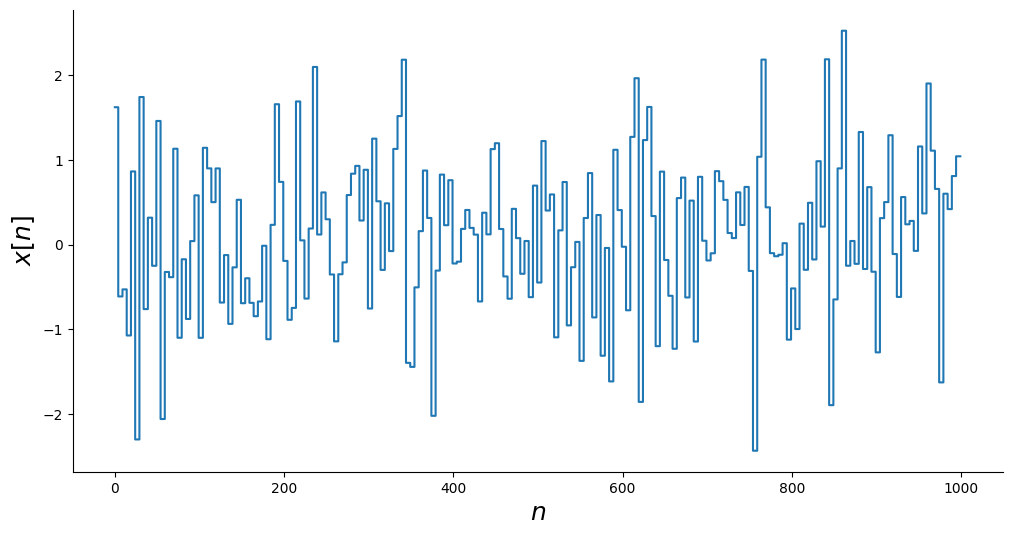

In [2]:
# Simulated system
def system_equation(y, u):
    yk = (
        (0.2 - 0.75 * np.cos(-y[0] ** 2)) * np.cos(y[0])
        - (0.15 + 0.45 * np.cos(-y[0] ** 2)) * np.cos(y[1])
        + np.cos(u[0])
        + 0.2 * u[1]
        + 0.7 * u[0] * u[1]
    )
    return yk


repetition = 5
random_samples = 200
total_time = repetition * random_samples
n = np.arange(0, total_time)

# Generating input
x = np.random.normal(size=(random_samples,)).repeat(repetition)


_, ax = plt.subplots(figsize=(12, 6))
ax.step(n, x)
ax.set_xlabel("$n$", fontsize=18)
ax.set_ylabel("$x[n]$", fontsize=18)
plt.show()

### Simulate the system

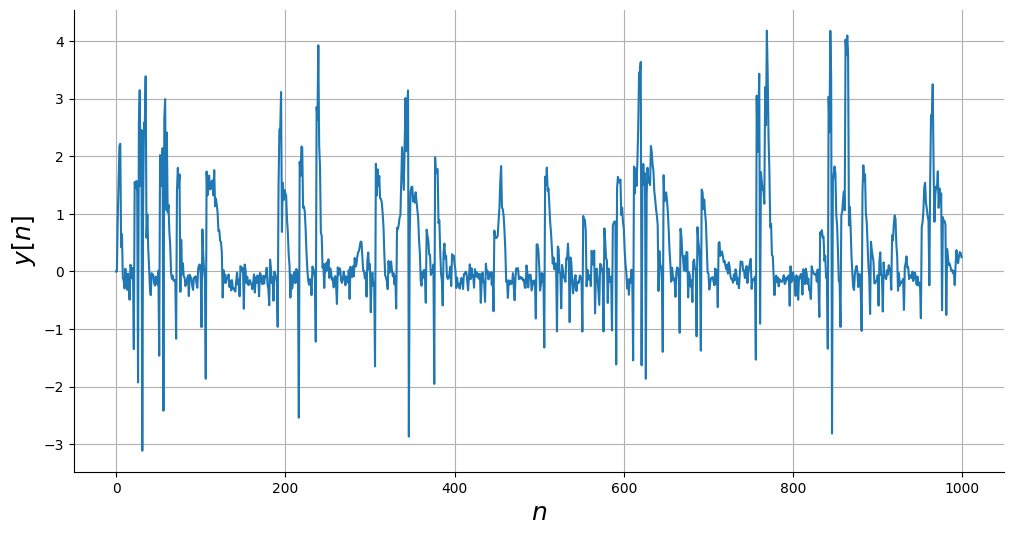

In [3]:
y = np.empty_like(x)
# Initial Conditions
y0 = [0, 0]

# Simulate it
y[0:2] = y0
for i in range(2, len(y)):
    y[i] = system_equation(
        [y[i - 1], y[i - 2]], [x[i - 1], x[i - 2]]
    ) + np.random.normal(scale=0.1)

# Plot
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(n, y)
ax.set_xlabel("$n$", fontsize=18)
ax.set_ylabel("$y[n]$", fontsize=18)
ax.grid()
plt.show()

### Adding noise to the system

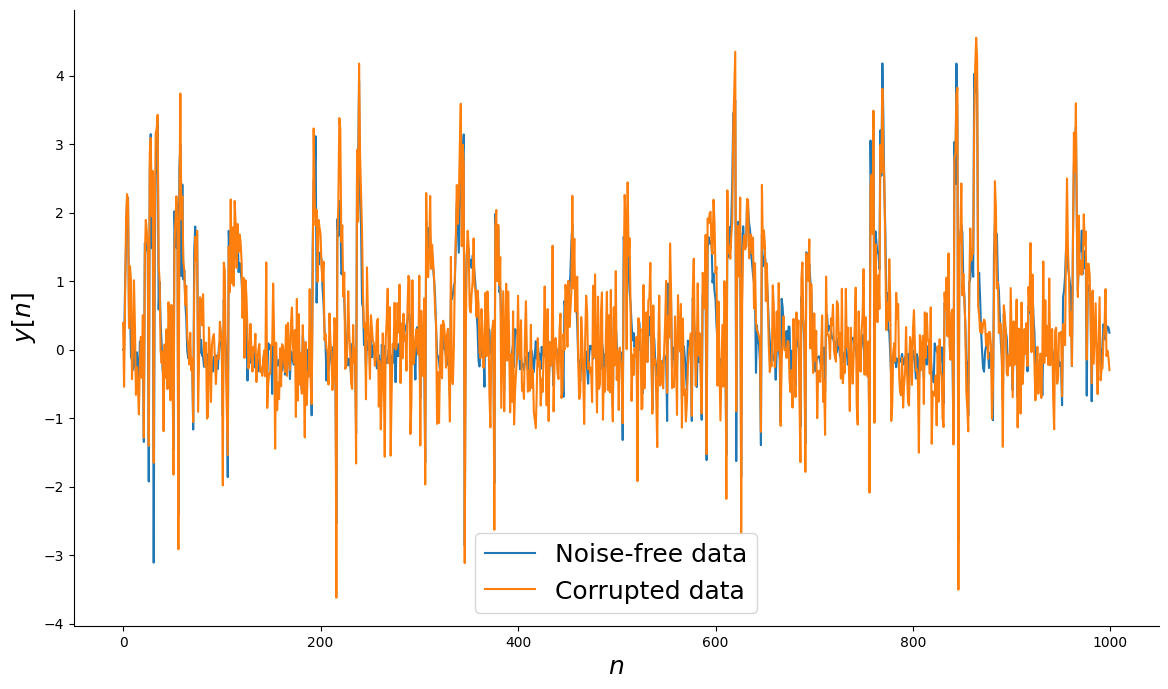

In [4]:
# Noise free data
ynoise_free = y.copy()

# Generate noise
v = np.random.normal(scale=0.5, size=y.shape)

# Data corrupted with noise
ynoisy = ynoise_free + v

# Plot
_, ax = plt.subplots(figsize=(14, 8))
ax.plot(n, ynoise_free, label="Noise-free data")
ax.plot(n, ynoisy, label="Corrupted data")
ax.set_xlabel("$n$", fontsize=18)
ax.set_ylabel("$y[n]$", fontsize=18)
ax.legend(fontsize=18)
plt.show()

### Generating training and test data

In [5]:
n_train = 700

# Identification data
y_train = ynoisy[:n_train].reshape(-1, 1)
x_train = x[:n_train].reshape(-1, 1)

# Validation data
y_test = ynoise_free[n_train:].reshape(-1, 1)
x_test = x[n_train:].reshape(-1, 1)

### Polynomial Basis Function

As you can see bellow, using only the polynomial basis function with the following parameters do not result in a bad model. However, lets check how is the performance using the Fourier Basis Function.

0.6768251106751224


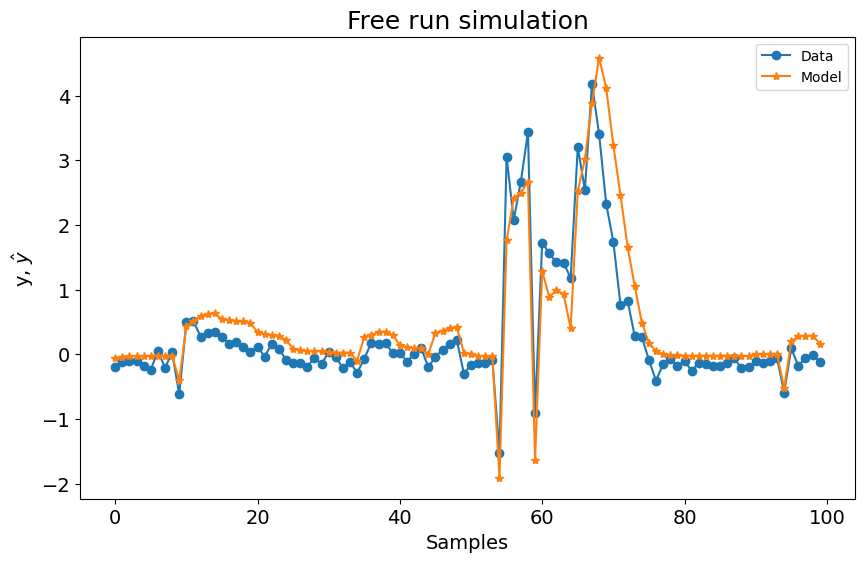

In [26]:
basis_function = Polynomial(degree=2)
estimator = LeastSquares()

sysidentpy = FROLS(
    order_selection=True,
    n_info_values=15,
    xlag=2,
    ylag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    estimator=estimator,
    err_tol=None,
)
sysidentpy.fit(X=x_train, y=y_train)

yhat = sysidentpy.predict(X=x_test, y=y_test)
frols_loss = root_relative_squared_error(
    y_test[sysidentpy.max_lag :], yhat[sysidentpy.max_lag :]
)
print(frols_loss)

plot_results(y=y_test[sysidentpy.max_lag :], yhat=yhat[sysidentpy.max_lag :])

### Ensembling a Fourier Basis Function

In this case, adding the Fourier Basis Function solves the problem and returns a model capable to predict the defined system

0.3742244715879492


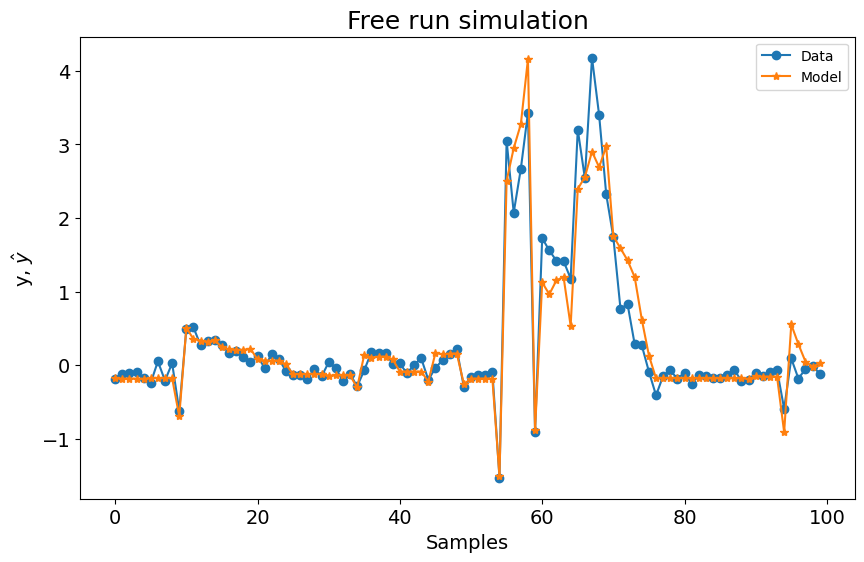

In [13]:
basis_function = Fourier(degree=2, n=2, p=2 * np.pi, ensemble=True)
sysidentpy = FROLS(
    order_selection=True,
    n_info_values=70,
    xlag=2,
    ylag=2,  # the lags for all models will be 13
    basis_function=basis_function,
    model_type="NARMAX",
    err_tol=None,
)
sysidentpy.fit(X=x_train, y=y_train)

yhat = sysidentpy.predict(X=x_test, y=y_test)
frols_loss = root_relative_squared_error(
    y_test[sysidentpy.max_lag :], yhat[sysidentpy.max_lag :]
)
print(frols_loss)

plot_results(y=y_test[sysidentpy.max_lag :], yhat=yhat[sysidentpy.max_lag :])

## Important

Currently you can't get the model representation using `sysidentpy.regressor_code` for Fourier NARX models. Actually, you can use the method, but the representation is not accurate because we don't make clear what are the regressors related to the polynomial or related to the fourier basis function. This is a improvement to be done in future updates!